In [1]:
%run ./Vlad_Dissertation.ipynb

/home/renato/.virtualenvs/pps/lib/python3.11/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
/tmp/ipykernel_17925/1247435164.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


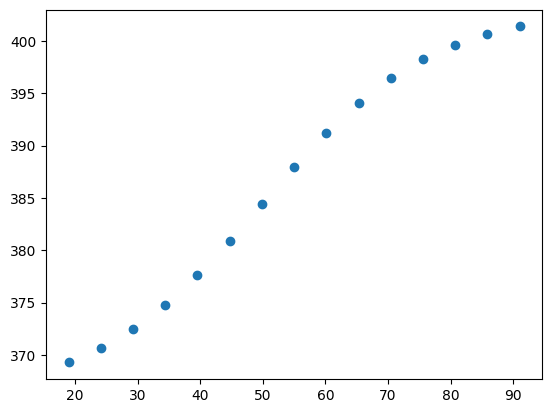

In [3]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
s_distances_sec = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
mydistances = 100 - s_distances_sec * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###Healthy Controls
ymin = 366
ymax = 403
scz_cp = 100 - 1.666 * 30
scz_slope = 1 / 0.075

SCZ_RTs = RTsig(mydistances, scz_cp, scz_slope)
plt.scatter(mydistances, SCZ_RTs)

In [4]:
from scipy.optimize import differential_evolution

HCWat, HCWvt, HCWav = crossmodal(1.3, 2, 1.3, 2, 1.3, 2)
HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)


def sczmodelrun(theta):
    HCWt, HCWa, HCWv, SCZBt, SCZBa, SCZBv = FwFb(
        6.5,
        6.5,
        6.5,
        theta[0],
        theta[0],
        theta[0],
        1.185e01,
        7.769e02,
        3.881e01,
        9.517e-01,
    )
    _, _, _, _, SCZrt = experiment(
        ts,
        simtime,
        mydistances,
        5,
        HCLt,
        HCLa,
        HCLv,
        HCWt,
        HCWa,
        HCWv,
        SCZBt,
        SCZBa,
        SCZBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        0,
    )

    xf = SCZrt
    yf = SCZ_RTs

    m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
        xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
    )
    bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

    if bias < 0:
        bias = 0
    if m < 0:
        m = 0

    cost = np.sum(np.square(np.divide(yf - (m * xf + bias), yf)))

    return cost * 100000


bounds = [(4.5, 6.55)]
sczres = differential_evolution(
    sczmodelrun, bounds, disp=True, workers=-1, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 14.023310937334427
differential_evolution step 2: f(x)= 14.023310937334427
differential_evolution step 3: f(x)= 14.023310937334427
differential_evolution step 4: f(x)= 13.8681991614288
differential_evolution step 5: f(x)= 13.339119212388566
differential_evolution step 6: f(x)= 12.975886198517301
differential_evolution step 7: f(x)= 12.975886198517182
differential_evolution step 8: f(x)= 12.975886198517182
differential_evolution step 9: f(x)= 12.975886198517182
differential_evolution step 10: f(x)= 12.975886198517182
differential_evolution step 11: f(x)= 12.975886198517182
differential_evolution step 12: f(x)= 12.975886198517182
differential_evolution step 13: f(x)= 12.975886198517182


In [5]:
print(sczres)

             message: Optimization terminated successfully.
             success: True
                 fun: 12.975886198517182
                   x: [ 4.617e+00]
                 nit: 13
                nfev: 210
          population: [[ 4.617e+00]
                       [ 4.633e+00]
                       ...
                       [ 4.617e+00]
                       [ 4.622e+00]]
 population_energies: [ 1.298e+01  1.329e+01 ...  1.298e+01  1.324e+01]


In [7]:
## Fitted model

B0 = 4.617e00

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(1.3, 2, 1.3, 2, 1.3, 2)
HCWt, HCWa, HCWv, SCZBt, SCZBa, SCZBv = FwFb(
    6.5, 6.5, 6.5, B0, B0, B0, 1.185e01, 7.769e02, 3.881e01, 9.517e-01
)
_, _, _, _, SCZ_Model_RTs = experiment(
    ts,
    simtime,
    mydistances,
    5,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa,
    HCWv,
    SCZBt,
    SCZBa,
    SCZBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

1.0205586447679442 267.94992256022084


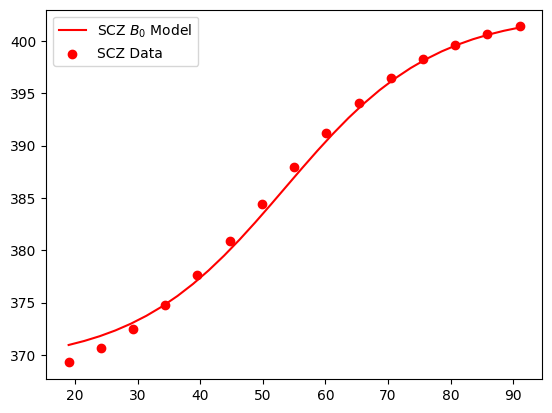

In [8]:
xf = SCZ_Model_RTs
yf = SCZ_RTs
m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
    xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
)
bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

ymin, ymax = np.min(m * xf + bias), np.max(m * xf + bias)
dc, h = fitting(mydistances, m * xf + bias)
mydistances_exp = np.linspace(mydistances[0], mydistances[-1], 30)
yf_exp = RTsig(mydistances_exp, dc, h)

plt.figure(1)
plt.plot(mydistances_exp, yf_exp, label="SCZ $B_0$ Model", color="r")
plt.scatter(mydistances, yf, label="SCZ Data", color="r")
plt.legend()
print(m, bias)

In [9]:
from sklearn import metrics

print(metrics.root_mean_squared_error(yf, m * xf + bias))

1.1675936902928232


In [10]:
def adjrmse(model, data, k):
    sse = np.sum(np.square(data - model))
    n = len(model)
    return np.sqrt(sse / (n - k))


scz_error = adjrmse(m * xf + bias, yf, 3)
print(scz_error)

1.3054094307972945
